In [1]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re

# Avalanche Risk Data

## Data preparation

In [2]:
df = pickle.load(open("../data/lawinenwarndienst/warning_levels.p", "rb"))

In [3]:
df.index = pd.to_datetime(df.index, dayfirst = True)

In [4]:
# Only retain timesteps with division in six zones
df_zones = df["2018-04-09":"2008-02-03"]

# Only retain the two first digits (warning levels)
df_zones_dangers = df_zones.replace(r".{3}$", "", regex = True)

In [5]:
def separate_zones(df):
    output = pd.DataFrame()
    for i in df:
        zone = df[i].str.split("", expand = True).iloc[:,1:3]
        zone = zone.melt(ignore_index = False, var_name = "low_high", value_name = "danger_level")
        zone["zone"] = i
        # zone["zone"] = i
        output = output.append(zone)
    output["Jahr"] = output.index.year
    return output

In [6]:
df_long = separate_zones(df_zones_dangers)
df_long = df_long[~(df_long["danger_level"] == "0")]
df_long["zone"] = df_long["zone"].replace([1, 2, 3, 4, 5, 6], ["Allgäuer Alpen", "Ammergauer Alpen", "Werdenfelser Alpen", "Bayerische Voralpen", "Chiemgauer Alpen", "Berchtesgadener Alpen"])
df_long = df_long.rename(columns = {"zone": "Zone", "danger_level": "Warnstufe"})

In [7]:
df_long["Saison"] = 1
for i in range(2008, 2018, 1):
    df_long.Saison[df_long.index > f"{i}-08-01"] += 1

<ipython-input-7-2933f21f057b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long.Saison[df_long.index > f"{i}-08-01"] += 1
/home/daniel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Basic descriptive statistics

In [8]:
df_zones_dangers.shape, df_long.shape

((1416, 6), (16986, 5))

### How often are low and high equal?

In [9]:
lower_values = df_zones_dangers.replace(r"^.{1}", "", regex = True).apply(lambda x: x.astype(int))
upper_values = df_zones_dangers.replace(r".{1}$", "", regex = True).apply(lambda x: x.astype(int))

In [10]:
((upper_values - lower_values) == 0).sum() / df_zones_dangers.shape[0] * 100

1    45.692090
2    51.200565
3    43.220339
4    60.381356
5    60.593220
6    44.420904
dtype: float64

The levels are equal equal in between 43% to 60%

### How are the differences distributed?

<AxesSubplot:>

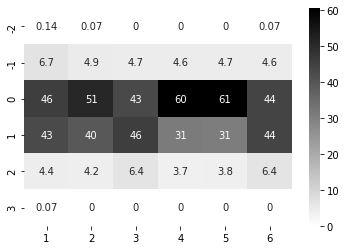

In [11]:
differences_danger = (upper_values - lower_values).apply(pd.Series.value_counts, normalize = True).mul(100).round(2).fillna(0)
sns.heatmap(differences_danger, cmap = "binary", annot = True)

In most cases, both levels are equal or the "upper" value is 1 larger. Seldom, "upper" is lower or 2 steps larger than "lower".

## Visualizations

### "Smoothed" course of levels over the year

In [13]:
rolling_mean = pd.DataFrame(df_long.groupby(["Saison", "low_high"])["Warnstufe"].rolling("10d").mean()).reset_index()

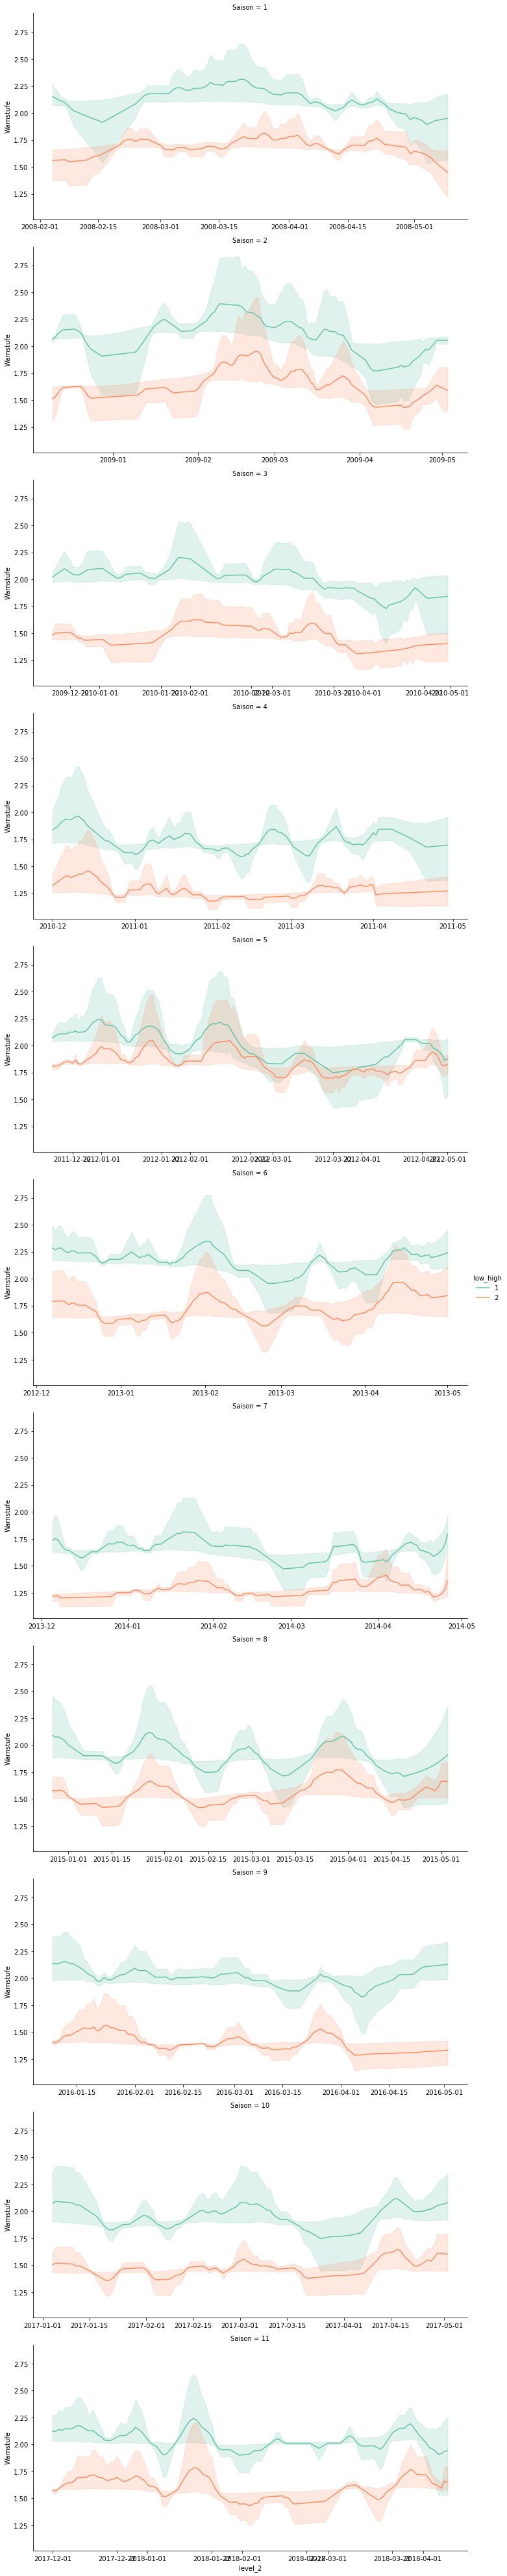

In [14]:
sns.relplot(data = rolling_mean, x = "level_2", y = "Warnstufe", hue = "low_high", kind = "line", row = "Saison", aspect = 2, facet_kws = dict(sharex = False, sharey = True), palette = "Set2")

In [15]:
rolling_mean = pd.DataFrame(df_long.groupby(["Saison", "Zone", "low_high"])["Warnstufe"].rolling("10d").mean()).reset_index()

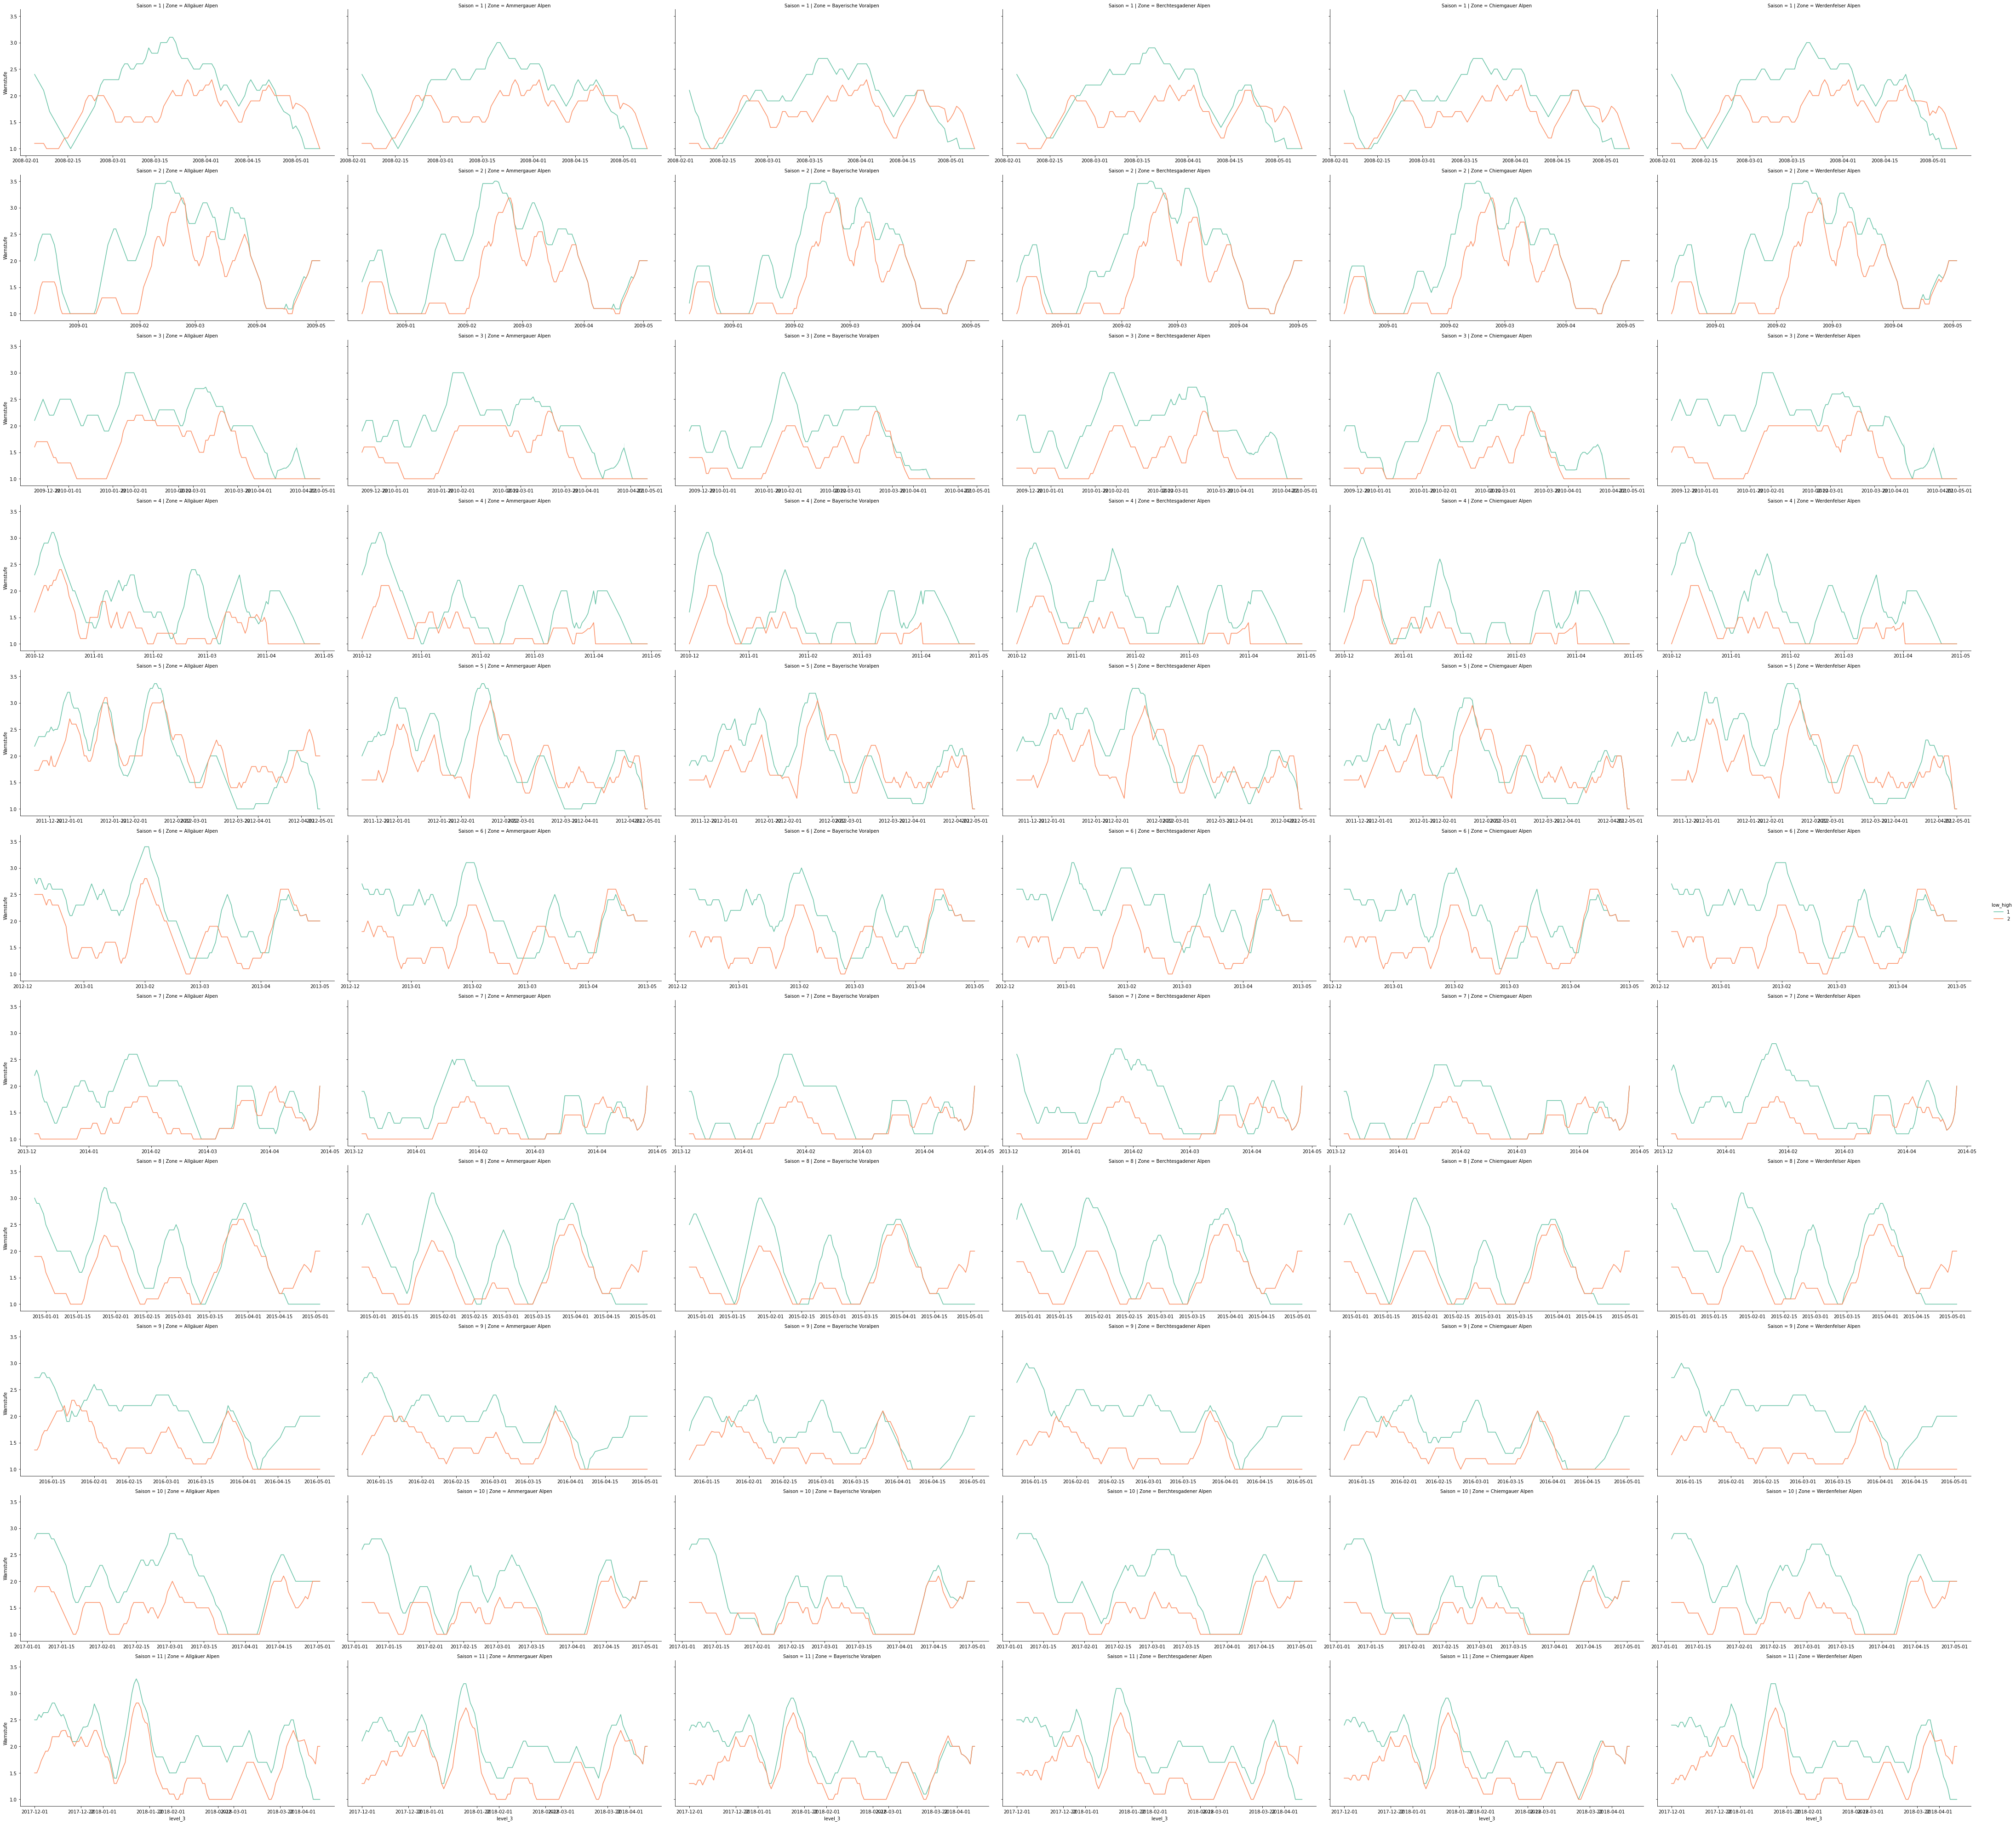

In [16]:
sns.relplot(data = rolling_mean, x = "level_3", y = "Warnstufe", hue = "low_high", kind = "line", row = "Saison", col = "Zone", aspect = 2, facet_kws = dict(sharex = False, sharey = True), palette = "Set2")

### "Warnstufe" counts depending on zone and year

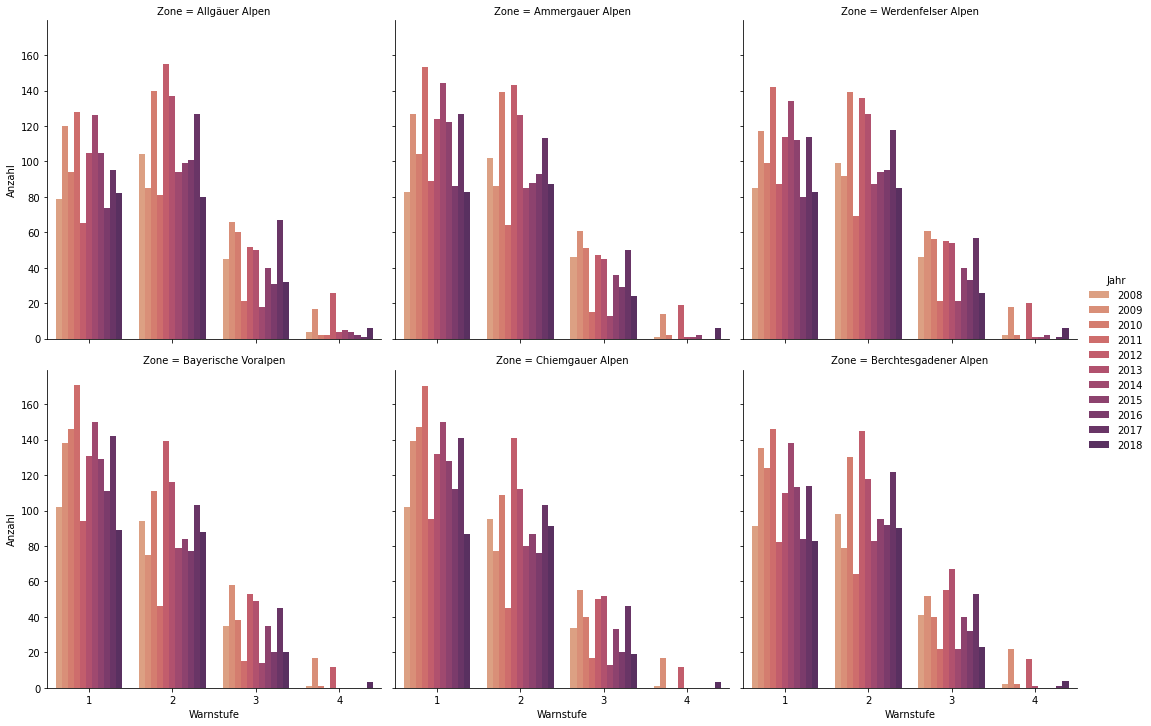

In [17]:
g = sns.catplot(data = df_long, x = "Warnstufe", kind = "count", hue = "Jahr", col = "Zone", col_wrap = 3, palette = "flare")
g.set_axis_labels("Warnstufe", "Anzahl")
g.savefig("barplot_zone_jahr.png", dpi = 300, pad_inches = 0.8)

### "Warnstufe" counts depending on year and zone

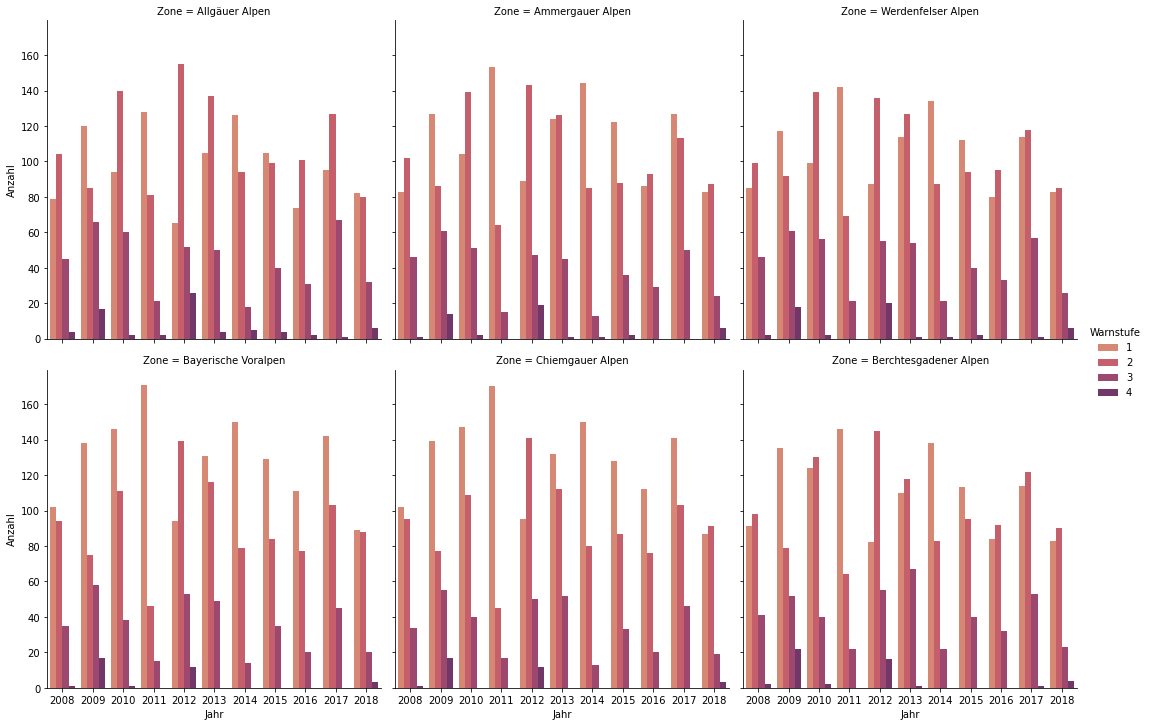

In [18]:
g = sns.catplot(data = df_long, x = "Jahr", kind = "count", hue = "Warnstufe", col = "Zone", col_wrap = 3, palette = "flare")
g.set_axis_labels("Jahr", "Anzahl")
g.savefig("barplot_jahr_zone.png", dpi = 300, pad_inches = 0.8)

### "Warnstufe" vs zone (counts) over all years

<AxesSubplot:xlabel='Warnstufe', ylabel='Zone'>

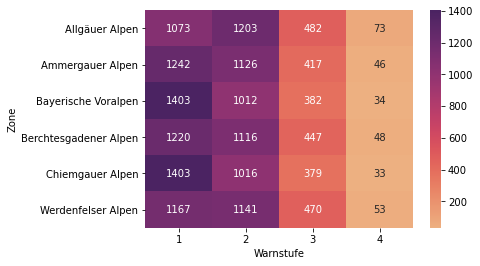

In [19]:
z = df_long.groupby(["Zone"])["Warnstufe"].value_counts().unstack()
sns.heatmap(data = z, cmap = "flare", annot = True, fmt = "d")

### "Warnstufe" vs. zone depending on year

/home/daniel/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


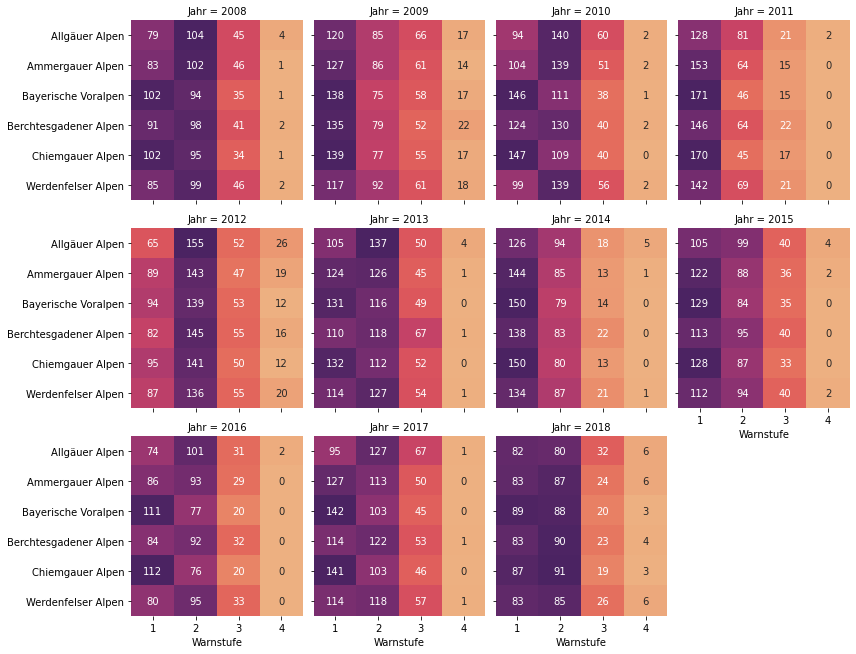

In [20]:
def facet(data, color):
    data = data.groupby(["Zone"])["Warnstufe"].value_counts().unstack().fillna(0)
    sns.heatmap(data, cbar = False, square = False, annot = True, cmap = "flare", fmt = "0g")
    
g = sns.FacetGrid(df_long, col = "Jahr", col_wrap = 4, size = 3)
g.map_dataframe(facet)
g.set_axis_labels("Warnstufe", "")
g.savefig("heatmap.png", dpi = 300, pad_inches = 0.8)

/home/daniel/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


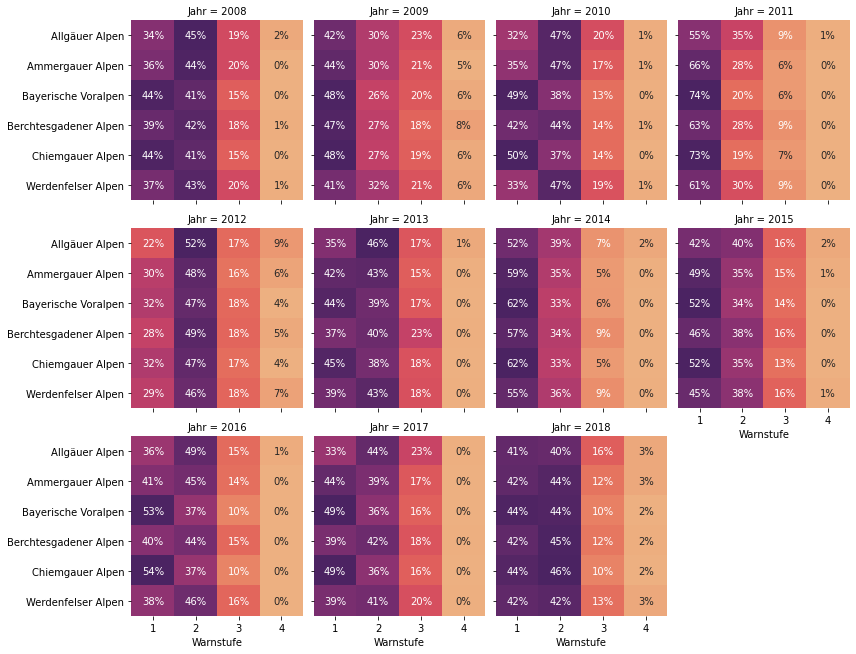

In [21]:
def facet(data, color):
    data = data.groupby(["Zone"])["Warnstufe"].value_counts(normalize = True).unstack().fillna(0)
    sns.heatmap(data, cbar = False, square = False, annot = True, cmap = "flare", fmt = ".0%")
    
g = sns.FacetGrid(df_long, col = "Jahr", col_wrap = 4, size = 3)
g.map_dataframe(facet)
g.set_axis_labels("Warnstufe", "")
g.savefig("heatmap_prozent.png", dpi = 300, pad_inches = 0.8)

# Weather data

Only look at a single measurement station (Allgäu - Hochgrat-Hörmoos) to start with

## Variables

### TS: snow temperature

* measured at different levels (00, 02, 04, 06), in different files

### TO: Surface temperature

* some outliers with too high temperatures
* see `np.where(t0["T0"] > 10)[0].tolist()`
* all above 12°C is outlier

### Nsgew: Precipitation weight

### N: Precipitation

* unit: mm

### LT: Air temperature

### LF: relative humidity

### HS snow height

### NW: Precipitation yes/no

### WR: Wind direction

* exists as WR and WT.boe

### WG: Wind velocity

* exists as WG and WG.boe

## Import

In [2]:
WEATHER_FILEPATH = "../data/lawinenwarndienst/weather_data/1-allgaeu/hochgrat-hoermoos/"

In [11]:
os.listdir(WEATHER_FILEPATH)

['lwz_Bayern_86991032-T0-Basisganglinie.csv',
 'lwz_Bayern_05100419-WG-Basisganglinie.csv',
 'lwz_Bayern_86991032-N-Basisganglinie.csv',
 'lwz_Bayern_86991032-LT-Basisganglinie.csv',
 'lwz_Bayern_05100419-WR-Basisganglinie.csv',
 'lwz_Bayern_86991032-TS.020-Basisganglinie.csv',
 'lwz_Bayern_86991032-TS.000-Basisganglinie.csv',
 'lwz_Bayern_86991032-TS.060-Basisganglinie.csv',
 'lwz_Bayern_05100419-LD-Basisganglinie.csv',
 'lwz_Bayern_86991032-Nsgew-Basisganglinie.csv',
 'lwz_Bayern_05100419-WG.Boe-Basisganglinie.csv',
 'lwz_Bayern_86991032-TS.040-Basisganglinie.csv',
 'lwz_Bayern_86991032-LF-Basisganglinie.csv',
 'lwz_Bayern_05100419-LF-Basisganglinie.csv',
 'lwz_Bayern_86991032-HS-Basisganglinie.csv',
 'lwz_Bayern_05100419-NW-Basisganglinie.csv',
 'lwz_Bayern_05100419-WR.Boe-Basisganglinie.csv',
 'lwz_Bayern_05100419-LT-Basisganglinie.csv']

In [110]:
def import_file(folder, file):
    metric = re.findall(r"(?<=-).+(?=-)", file)[0]
    station = re.findall(r"\d{8}", file)[0]
    df = pd.read_csv(folder + file, index_col = False, skiprows = 15, names = ["date", metric])
    df["date"] = df["date"].replace(r";.+", "", regex = True)
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace = True)
    df["station"] = station
    return df

In [237]:
def show_data_overview(df):
    print(f"Shape: {df.shape}\n")
    print(f"Info: {df.info()}\n")
    print(f"Describe: {df.describe()}\n")
    print(f"Head:\n{df.head()}\n")
    print(f"Value counts:\n{df.iloc[:,0].value_counts()}\n")
    sns.displot(x = df.iloc[:,0])
    subset = df.loc["2012-01-09":"2012-01-09"]
    sns.lineplot(y = subset.iloc[:,0], x = subset.index)
    plt.xticks(rotation = 45)

# T0 - Surface Temperature

In [233]:
t0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306577 entries, 2012-01-09 00:00:00 to 2018-01-07 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   T0       269661 non-null  float64
 1   station  306577 non-null  object 
dtypes: float64(1), object(1)
memory usage: 7.0+ MB


In [222]:
t0 = import_file(WEATHER_FILEPATH, "lwz_Bayern_86991032-T0-Basisganglinie.csv")

Shape: (306577, 2)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 306577 entries, 2012-01-09 00:00:00 to 2018-01-07 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   T0       269661 non-null  float64
 1   station  306577 non-null  object 
dtypes: float64(1), object(1)
memory usage: 17.0+ MB
Info: None

Describe:                  T0
count  2.696610e+05
mean   7.421670e+03
std    2.330376e+06
min    1.000000e+00
25%    3.000000e+00
50%    5.000000e+00
75%    7.000000e+00
max    9.333333e+08

Head:
                      T0   station
date                              
2012-01-09 00:00:00  2.0  86991032
2012-01-09 00:10:00  2.0  86991032
2012-01-09 00:20:00  1.0  86991032
2012-01-09 00:30:00  1.0  86991032
2012-01-09 00:40:00  2.0  86991032

Value counts:
1.0            31634
3.0            31358
2.0            31236
4.0            30759
5.0            30434
6.0            29374
7.0            28888
8.0        

MemoryError: Unable to allocate 56.2 GiB for an array with shape (7537364236,) and data type float64

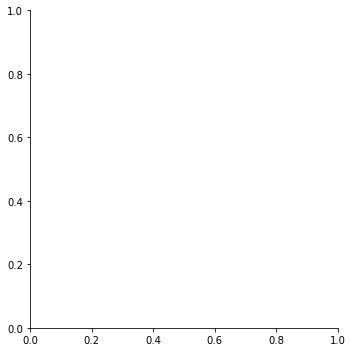

In [238]:
show_data_overview(t0)

<AxesSubplot:xlabel='date', ylabel='T0'>

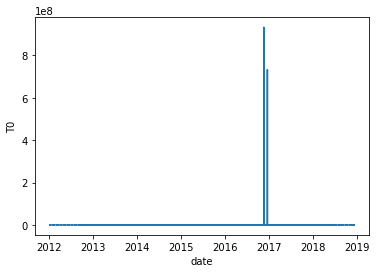

In [239]:
subset = t0.loc["2012-01-09":"2012-01-09"]
sns.lineplot(y = subset.iloc[:,0], x = subset.index)

In [112]:
t0.shape

(306577, 2)

In [116]:
t0.head()

,T0,station
date,,
2012-01-09 00:00:00,2.0,86991032
2012-01-09 00:10:00,2.0,86991032
2012-01-09 00:20:00,1.0,86991032
2012-01-09 00:30:00,1.0,86991032
2012-01-09 00:40:00,2.0,86991032


In [186]:
t0.index[0] + pd.Timedelta(weeks = 0)

Timestamp('2012-01-09 00:00:00')

In [188]:
# Replace outliers
t0[t0["T0"] > 12] = np.nan

In [168]:
t0_subset = t0.loc["2012-01-09":"2012-01-09"]

In [189]:
t0_subset

,T0,station
date,,
2012-01-09 00:00:00,2.0,86991032
2012-01-09 00:10:00,2.0,86991032
2012-01-09 00:20:00,1.0,86991032
2012-01-09 00:30:00,1.0,86991032
2012-01-09 00:40:00,2.0,86991032
...,...,...
2012-01-09 23:10:00,2.0,86991032
2012-01-09 23:20:00,1.0,86991032
2012-01-09 23:30:00,9.0,86991032


Auffällig: Von 1 auf 9°C zwischen 23:10 und 23:20?

(array([15348.   , 15348.125, 15348.25 , 15348.375, 15348.5  , 15348.625,
        15348.75 , 15348.875, 15349.   ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

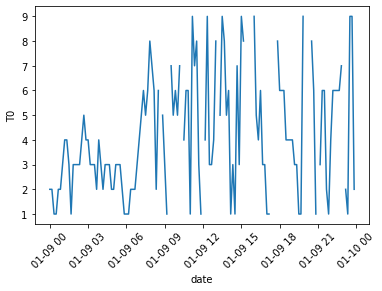

In [170]:
sns.lineplot(y = t0_subset["T0"], x = t0_subset.index)
plt.xticks(rotation = 45)

Wirkt sehr erratisch

In [187]:
t0["T0"].value_counts()

1.0     31634
3.0     31358
2.0     31236
4.0     30759
5.0     30434
6.0     29374
7.0     28888
8.0     28044
9.0     27922
15.0        1
Name: T0, dtype: int64

Verteilung wirkt seltsam

# WG - Wind velocity

In [190]:
wg = import_file(WEATHER_FILEPATH, "lwz_Bayern_05100419-WG-Basisganglinie.csv")

In [191]:
wg.head()

,WG,station
date,,
2012-01-09 00:00:00,71.0,05100419
2012-01-09 00:10:00,24.0,05100419
2012-01-09 00:20:00,5.0,05100419
2012-01-09 00:30:00,3.0,05100419
2012-01-09 00:40:00,26.0,05100419


In [210]:
wg["WG"].value_counts()

1.0     5618
7.0     5567
3.0     5528
5.0     5527
6.0     5521
        ... 
83.0    2624
94.0    2619
98.0    2614
95.0    2610
96.0    2606
Name: WG, Length: 90, dtype: int64

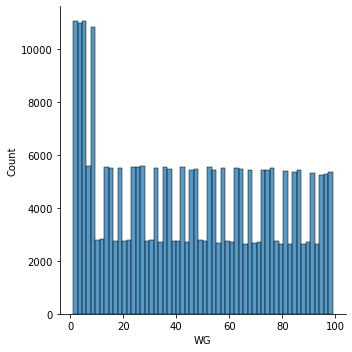

In [199]:
sns.displot(data = wg, x = "WG")

Sieht auffällig aus

In [204]:
wg_subset = wg.loc["2012-01-09":"2012-01-09"]

<AxesSubplot:xlabel='date', ylabel='WG'>

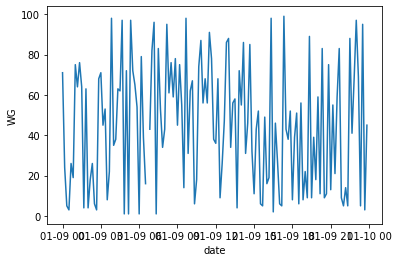

In [205]:
sns.lineplot(x = wg_subset.index, y = wg_subset["WG"])

In [208]:
wg_subset = wg.loc["2012-01-09-00":"2012-01-09-02"]

<AxesSubplot:xlabel='date', ylabel='WG'>

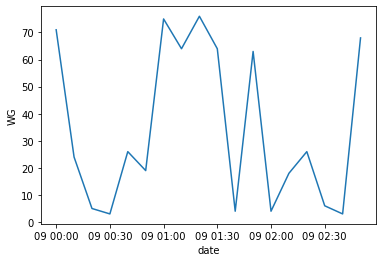

In [209]:
sns.lineplot(x = wg_subset.index, y = wg_subset["WG"])

# N - Precipitation

In [212]:
n = import_file(WEATHER_FILEPATH, "lwz_Bayern_86991032-N-Basisganglinie.csv")

In [213]:
n.shape

(306577, 2)

In [215]:
n.head()

,N,station
date,,
2012-01-09 00:00:00,2.0,86991032
2012-01-09 00:10:00,3.0,86991032
2012-01-09 00:20:00,2.0,86991032
2012-01-09 00:30:00,2.0,86991032
2012-01-09 00:40:00,2.0,86991032


In [216]:
n.N.value_counts()

1.0    16128
2.0     7861
3.0     4677
4.0     2972
5.0     2055
6.0     1519
7.0     1050
8.0      812
9.0      636
Name: N, dtype: int64